In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gate import AddGate, MultiplyGate, DotGate, BiasGate, SigmoidGate, ReluGate, SoftmaxGate
from utils import random_mini_batches, plot_decision_boundary

In [2]:
np.random.seed(1)

In [3]:
def load_dataset():
    np.random.seed(1)
    m = 800 # number of examples
    C = 4
    N = int(m/C) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 7 # maximum ray of the flower
    for j in range(C):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(3*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t+j*3.14/2), r*np.cos(t+j*3.14/2)]
        Y[ix] = j
        pass 
    X = X.T
    Y = Y.T
    return X, Y

In [4]:
X, Y = load_dataset()

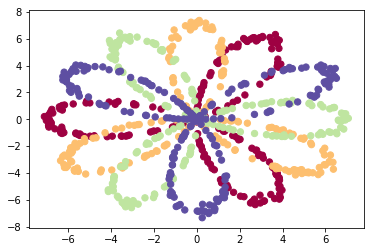

In [5]:
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(X.shape)
print(Y.shape)

(2, 800)
(1, 800)


In [7]:
n_classes = np.max(np.squeeze(Y)) + 1
Y_softmax = np.eye(n_classes)[np.squeeze(Y)]
Y_softmax = Y_softmax.T
print(Y_softmax)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [8]:
print(Y_softmax.shape)

(4, 800)


In [9]:
parameters = {}
parameters['W1'] = np.random.randn(25, 2) * np.sqrt(2 / 2)
parameters['b1'] = np.zeros((25, 1))
parameters['W2'] = np.random.randn(12, 25) * np.sqrt(2 / 25)
parameters['b2'] = np.zeros((12, 1))
parameters['W3'] = np.random.randn(4, 12) * np.sqrt(2 / 12)
parameters['b3'] = np.zeros((4, 1))
v = {}
v['dW1'] = np.zeros((parameters['W1'].shape[0], parameters['W1'].shape[1]))
v['db1'] = np.zeros((parameters['b1'].shape[0], parameters['b1'].shape[1]))
v['dW2'] = np.zeros((parameters['W2'].shape[0], parameters['W2'].shape[1]))
v['db2'] = np.zeros((parameters['b2'].shape[0], parameters['b2'].shape[1]))
v['dW3'] = np.zeros((parameters['W3'].shape[0], parameters['W3'].shape[1]))
v['db3'] = np.zeros((parameters['b3'].shape[0], parameters['b3'].shape[1]))

In [10]:
d1 = DotGate()
z1 = BiasGate()
a1 = ReluGate()
d2 = DotGate()
z2 = BiasGate()
a2 = ReluGate()
d3 = DotGate()
z3 = BiasGate()
a3 = SoftmaxGate()

In [11]:
def forward_propagation(X):
    # forward
    global parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    D1 = d1.forward(W1, X)
    Z1 = z1.forward(D1, b1)
    A1 = a1.forward(Z1)
    D2 = d2.forward(W2, A1)
    Z2 = z2.forward(D2, b2)
    A2 = a2.forward(Z2)
    D3 = d3.forward(W3, A2)
    Z3 = z3.forward(D3, b3)
    A3 = a3.forward(Z3)
    return A3

def compute_cost(Y, A):
    # cost
    n, m = Y.shape
    logprobs = -np.multiply(Y, np.log(A))
    cost = 1.0/m * np.nansum(logprobs)
    cost = np.squeeze(cost)
    return cost

def backward_propagation(Y, A):
    # backward
    n, m = Y.shape
    grads = {}
    dA3 = 1.0/m * -np.squeeze((Y/A))
    dZ3 = a3.backward(dA3)
    dD3, db3 = z3.backward(dZ3)
    dW3, dA2 = d3.backward(dD3)
    dZ2 = a2.backward(dA2)
    dD2, db2 = z2.backward(dZ2)
    dW2, dA1 = d2.backward(dD2)
    dZ1 = a1.backward(dA1)
    dD1, db1 = z1.backward(dZ1)
    dW1, _ = d1.backward(dD1)
    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    grads['dW3'] = dW3
    grads['db3'] = db3
    return grads

def update_parameters(grads, learning_rate, beta=0.9):
    # update
    global parameters, v
    v["dW1"] = beta * v["dW1"] + (1 - beta) * grads['dW1']
    v["db1"] = beta * v["db1"] + (1 - beta) * grads['db1']
    v["dW2"] = beta * v["dW2"] + (1 - beta) * grads['dW2']
    v["db2"] = beta * v["db2"] + (1 - beta) * grads['db2']
    v["dW3"] = beta * v["dW3"] + (1 - beta) * grads['dW3']
    v["db3"] = beta * v["db3"] + (1 - beta) * grads['db3']
    parameters['W1'] -= learning_rate*v['dW1']
    parameters['b1'] -= learning_rate*v['db1']    
    parameters['W2'] -= learning_rate*v['dW2']
    parameters['b2'] -= learning_rate*v['db2']
    parameters['W3'] -= learning_rate*v['dW3']
    parameters['b3'] -= learning_rate*v['db3']
    pass

In [12]:
mini_batch_costs = []
costs = []
lr = 0.025
seed = 0
for i in range(2500):
    cost = 0.0
    seed = seed + 1
    mini_batches = random_mini_batches(X, Y_softmax, seed=seed)
    for mini_batch in mini_batches:
        (minibatch_X, minibatch_Y) = mini_batch
        _, m_mini_batch = minibatch_X.shape
        # forward
        A3 = forward_propagation(minibatch_X)
        # cost
        mini_batch_cost = compute_cost(minibatch_Y, A3)
        mini_batch_costs.append(mini_batch_cost)
        cost += m_mini_batch * mini_batch_cost
        # backward
        grads = backward_propagation(minibatch_Y, A3)
        # update
        update_parameters(grads, learning_rate=lr)
        pass
    _, m = X.shape
    cost = cost / m
    costs.append(cost)
    if i%100 == 0 :
        print('Cost after epoch ' + str(i) + ': ' + str(cost))
        pass
    pass

Cost after epoch 0: 5.541636533431463
Cost after epoch 100: 0.7044289389164513
Cost after epoch 200: 0.6953508261617982
Cost after epoch 300: 0.6628967974016464
Cost after epoch 400: 0.6393050682622384
Cost after epoch 500: 0.6237308882946306
Cost after epoch 600: 0.6071466970372414
Cost after epoch 700: 0.5730918797244736
Cost after epoch 800: 0.5728595726089933
Cost after epoch 900: 0.5451214209467298
Cost after epoch 1000: 0.534568971949438
Cost after epoch 1100: 0.5118652063627505
Cost after epoch 1200: 0.46825170161439955
Cost after epoch 1300: 0.46382472515108786
Cost after epoch 1400: 0.44825199998463033
Cost after epoch 1500: 0.44590551365455977
Cost after epoch 1600: 0.4794735013361586
Cost after epoch 1700: 0.5165075727921533
Cost after epoch 1800: 0.4465114360686592
Cost after epoch 1900: 0.4191830858069831
Cost after epoch 2000: 0.3964471065957725
Cost after epoch 2100: 0.4129132580835265
Cost after epoch 2200: 0.3630296257785101
Cost after epoch 2300: 0.35864656483317975
C

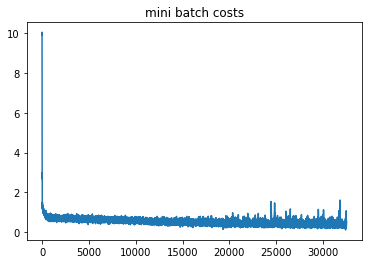

In [13]:
plt.plot(mini_batch_costs)
plt.title('mini batch costs')
plt.show()

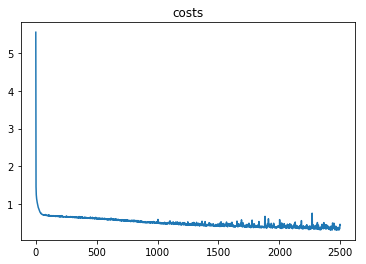

In [14]:
plt.plot(costs)
plt.title('costs')
plt.show()

In [15]:
def predict(X):
    n, m = X.shape
    # forward
    A3 = forward_propagation(X)
    predictions = np.squeeze(np.argmax(A3, axis=0))
    return predictions

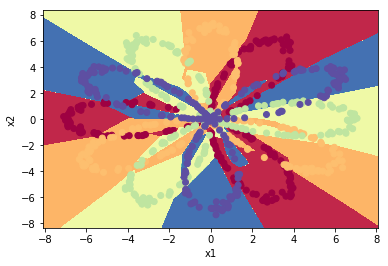

In [16]:
plot_decision_boundary(lambda x: predict(x.T), X, Y[0, :])